In [1]:
import pandas as pd
import numpy as np
import random
import re
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
# Vendor dictionary
vendors = {
    'Subscriptions': ['Netflix', 'Spotify', 'Apple Music', 'DSTV Premium', 'Showmax'],
    'Groceries': ['Shoprite', 'Spar', 'Market Square', 'Justrite', 'Prince Ebeano'],
    'Transport': ['Uber', 'Bolt', 'Indriver', 'Oando Fuel Stn', 'Total Energies'],
    'Food': ['Chicken Republic', 'The Place', 'Mega Chicken', 'Dominos Pizza', 'Chowdeck'],
    'Utilities': ['MTN VTU', 'Airtel Airtime', 'Ikeja Electric', 'Smile Data'],
    'Transfers': ['Trf to Emeka', 'Trf to Mum', 'Trf to Landlord', 'Trf to Sibling']
}

# Helper function: random date in last 90 days
def generate_random_date():
    end_date = datetime.now()
    start_date = end_date - timedelta(days=90)
    random_date = start_date + (end_date - start_date) * random.random()
    return random_date.strftime("%d-%b-%Y %H:%M")

# Helper function: realistic amount generator
def get_amount(category):
    if category == 'Subscriptions': return random.choice([4500, 1200, 900, 29000])
    if category == 'Groceries': return round(random.uniform(5000, 45000), 2)
    if category == 'Transport': return round(random.uniform(1500, 15000), 2)
    if category == 'Food': return round(random.uniform(2500, 12000), 2)
    if category == 'Utilities': return round(random.uniform(1000, 20000), 2)
    if category == 'Transfers': return round(random.uniform(5000, 150000), 2)
    return 1000.00

In [3]:
data = []
num_rows = 500

for _ in range(num_rows):
    category = random.choice(list(vendors.keys()))
    vendor = random.choice(vendors[category])
    amount = get_amount(category)
    date = generate_random_date()
    bank_type = random.choice(['Bank_A', 'Bank_B'])
    
    # GTBank-style
    if bank_type == 'Bank_A':
        sms = f"Acct: 123***45; Amt:N{amount:,.2f} DR; Desc:{vendor} POS Ref:88291; Date:{date}"
    
    # Access/Zenith style
    else:
        sms = f"Debit: NGN {amount:,.2f} for {vendor} @ Lagos on {date}. Ref:77281. Bal: NGN 45,000.20"
        
    data.append([date, sms, bank_type])

# Add noise (non-transaction SMS)
noise = pd.DataFrame([
    [generate_random_date(), "Dear Customer, protect your BVN. Do not disclose to anyone.", "Bank_A"],
    [generate_random_date(), "Happy Birthday! We wish you a wonderful year ahead.", "Bank_B"],
    [generate_random_date(), "Transaction Failed. Please try again later.", "Bank_A"]
], columns=['Date_Sent', 'SMS_Body', 'Bank_Source'])

df = pd.DataFrame(data, columns=['Date_Sent', 'SMS_Body', 'Bank_Source'])
df = pd.concat([df, noise]).sample(frac=1).reset_index(drop=True)

In [4]:
def extract_amount(sms):
    match = re.search(r'(?:N|NGN)\s?([\d,]+\.\d{2})', sms)
    if match:
        return float(match.group(1).replace(',', ''))
    return None

df['Amount'] = df['SMS_Body'].apply(extract_amount)

In [5]:
def extract_vendor(sms):
    match_a = re.search(r'Desc:\s*(.*?)(?:\s+POS|\s+Ref|;|$)', sms, re.IGNORECASE)
    match_b = re.search(r'for\s+(.*?)\s+@', sms, re.IGNORECASE)
    
    if match_a: return match_a.group(1).strip()
    if match_b: return match_b.group(1).strip()
    return None

df['Vendor'] = df['SMS_Body'].apply(extract_vendor)

In [6]:
clean_df = df.dropna(subset=['Amount', 'Vendor']).copy()

In [7]:
def clean_vendor_name(v):
    if v.lower().startswith("trf to"):
        return v[6:].strip()
    return v

clean_df['Vendor_Clean'] = clean_df['Vendor'].apply(clean_vendor_name)

In [8]:
def categorize_spend(vendor):
    vendor = vendor.lower()
    
    if any(x in vendor for x in ['shoprite', 'spar', 'market', 'justrite', 'ebeano']):
        return 'Groceries'
    elif any(x in vendor for x in ['uber', 'bolt', 'indriver', 'fuel', 'total']):
        return 'Transport'
    elif any(x in vendor for x in ['netflix', 'spotify', 'dstv', 'showmax']):
        return 'Subscriptions'
    elif any(x in vendor for x in ['chicken', 'place', 'dominos', 'chowdeck']):
        return 'Food'
    elif any(x in vendor for x in ['mtn', 'airtel', 'electric', 'data']):
        return 'Utilities'
    elif 'trf' in vendor:
        return 'Transfers'
    else:
        return 'Uncategorized'

clean_df['Category'] = clean_df['Vendor'].apply(categorize_spend)

In [9]:
clean_df['Date_Sent'] = pd.to_datetime(clean_df['Date_Sent'], format="%d-%b-%Y %H:%M")

In [10]:
def get_type(sms):
    sms = sms.upper()
    if 'DR' in sms or 'DEBIT' in sms:
        return 'Debit'
    if 'CR' in sms or 'CREDIT' in sms:
        return 'Credit'
    return 'Unknown'

clean_df['Transaction_Type'] = clean_df['SMS_Body'].apply(get_type)

In [11]:
clean_df['Month'] = clean_df['Date_Sent'].dt.to_period('M')
clean_df['Weekday'] = clean_df['Date_Sent'].dt.day_name()
clean_df['Hour'] = clean_df['Date_Sent'].dt.hour

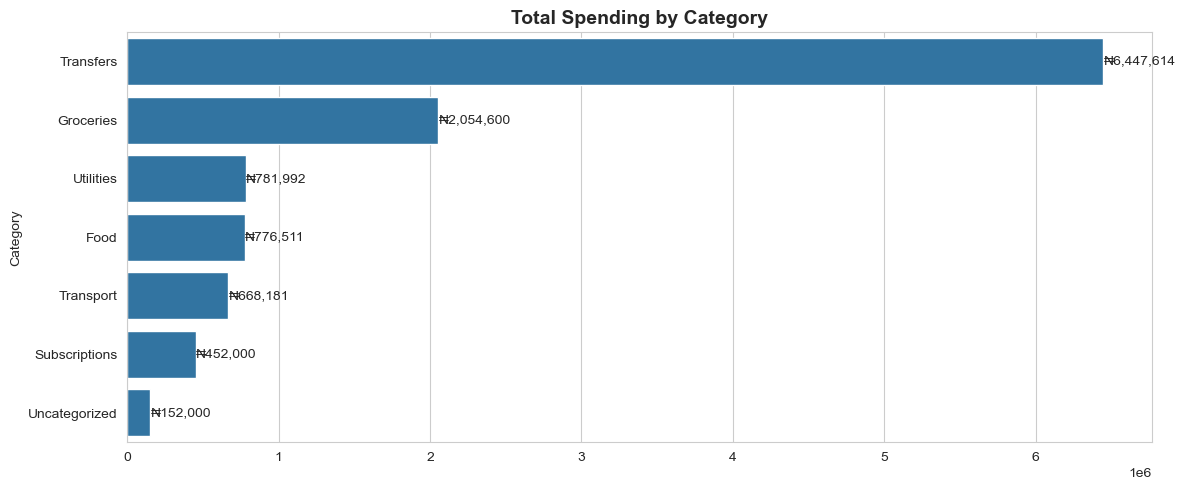

In [12]:
category_sum = clean_df.groupby('Category')['Amount'].sum().sort_values(ascending=False)

plt.figure(figsize=(12,5))
sns.barplot(x=category_sum.values, y=category_sum.index)
plt.title("Total Spending by Category", fontsize=14, fontweight='bold')

for i, v in enumerate(category_sum.values):
    plt.text(v + 500, i, f"₦{v:,.0f}", va='center')

plt.tight_layout()
plt.show()

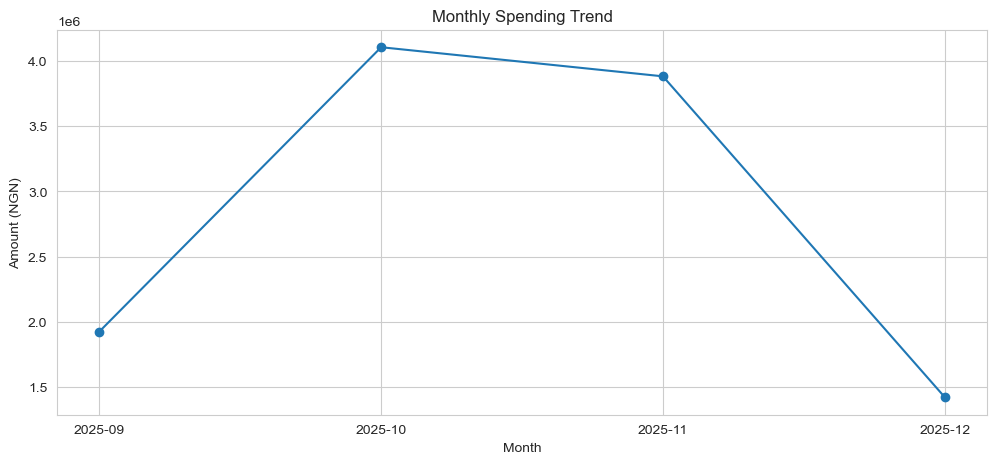

In [13]:
monthly = clean_df.groupby('Month')['Amount'].sum()

plt.figure(figsize=(12,5))
plt.plot(monthly.index.astype(str), monthly.values, marker='o')
plt.title("Monthly Spending Trend")
plt.xlabel("Month")
plt.ylabel("Amount (NGN)")
plt.grid(True)
plt.show()

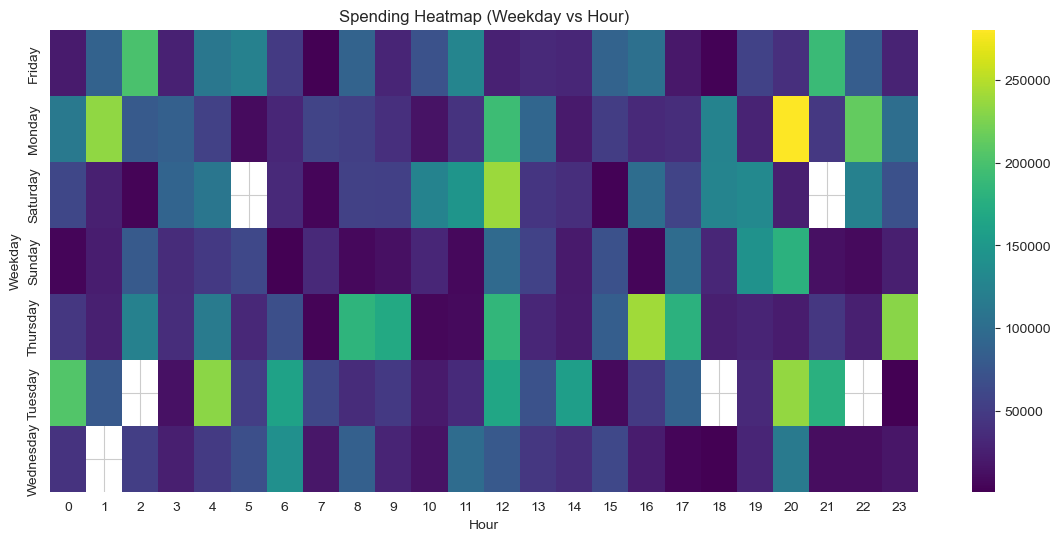

In [14]:
pivot = clean_df.pivot_table(
    values='Amount',
    index='Weekday',
    columns='Hour',
    aggfunc='sum'
)

plt.figure(figsize=(14,6))
sns.heatmap(pivot, cmap='viridis')
plt.title("Spending Heatmap (Weekday vs Hour)")
plt.show()

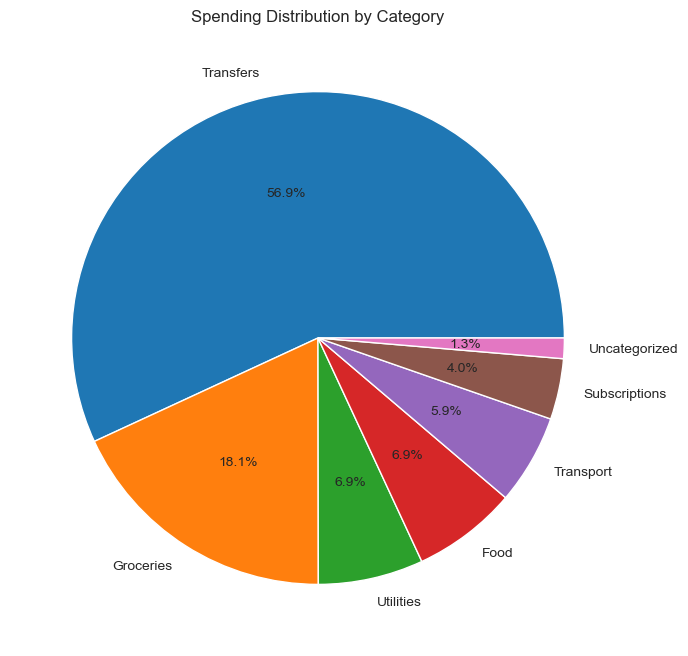

In [15]:
plt.figure(figsize=(8,8))
plt.pie(category_sum.values, labels=category_sum.index, autopct="%1.1f%%")
plt.title("Spending Distribution by Category")
plt.show()